In [5]:
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

TensorFlow 2.x selected.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
order = np.load('drive/My Drive/orderings.npy')
distances = np.load('drive/My Drive/distances.npy')
social = np.load('drive/My Drive/social.npy')

In [0]:
N = order.shape[0]
iters = order.shape[1]

In [0]:
X1 = []
X2 = []
Y = []

for t in range(iters):
    
    states = np.zeros(N)
    
    
    for i in range(N):
        j = int(order[i,t])
        depart = np.zeros(N)
        depart[j] = 1
        X1.append(states.copy())
        X2.append(distances[t])
        Y.append(depart)
        states[j]=1
        
    
    
X1 = np.array(X1)
X2 = np.array(X2)
Y = np.array(Y)

In [0]:
states = tf.convert_to_tensor(X1)
states = tf.expand_dims(states,-1)
dists = tf.convert_to_tensor(X2)
labels = tf.convert_to_tensor(Y)


@tf.function
def calc_loss(in_w1, in_b):
    D = in_w1*tf.exp(-dists)
    logits = tf.matmul(D,states)+in_b
    soft_denom = tf.reduce_sum(tf.where(states==0,tf.exp(logits),0),axis=1)
    soft_denom = tf.expand_dims(soft_denom,-1)
    softmax = tf.where(states==0,tf.exp(logits) / soft_denom ,0)

    softmax = tf.squeeze(softmax)
    bb = labels * tf.math.log(softmax+ 1e-10)
    cross_entropy = -tf.reduce_sum(labels * tf.math.log(softmax + 1e-10), 1)

    loss = tf.reduce_mean(cross_entropy)
    return loss

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=1e-2)


In [0]:

w1 = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float64))
b  = tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float64))

loss_history=[]
weight_history=[]
b_history=[]
def train_step():
    with tf.GradientTape() as tape:
    
        loss_value = calc_loss(w1, b)

    
    loss_history.append(loss_value.numpy())
    weight_history.append(w1.numpy())
    b_history.append(b.numpy())
    grads = tape.gradient(loss_value, [w1,b])
    optimizer.apply_gradients(zip(grads, [w1,b]))


In [0]:
for i in range(3000):
    train_step()

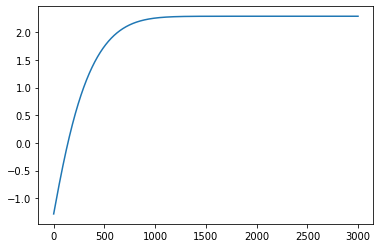

In [164]:
plt.plot(weight_history)
plt.show()

In [0]:
b_history


In [155]:
order[:,0]

array([4., 0., 2., 3., 7., 6., 8., 1., 5.])